### Anomaly detection and deep dive on Telecom data

**Problem Statement**: Detect anomalies in the nodes and protocols across all the markets

###### import packages

In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize    

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt 
import statsmodels.api as sm
import scipy.stats as scs

from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rstl import STL

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

##### load data

In [2]:
duration = pd.read_excel('DurationAndPayloadByMarketAndNodeAndProtocol.xlsx',sheet_name=0, header=1,skip_rows=1,usecols='A:G')

In [4]:
duration.head()

,DAY,MARKET,NODE,PROTOCOL,NON-LTE_SUM,ALL_RAT_TYPE_SUM,RATIO(%)
0,2018-08-01,LONG ISLAND,ATPCF003,dns,1.033,32757.240,0.003154
1,2018-08-01,LONG ISLAND,ATPCF003,facebook,541.823,32610.594,1.661494
2,2018-08-01,LONG ISLAND,ATPCF003,google,275.810,166010.554,0.166140
3,2018-08-01,LONG ISLAND,ATPCF003,http,123.289,6974.186,1.767791
4,2018-08-01,LONG ISLAND,ATPCF003,ssl,1.150,92909.692,0.001238


#### Market Level

In [16]:
df = duration[pd.notnull(duration['RATIO(%)'])]
df = df.groupby(['DAY','MARKET']).aggregate({'NON-LTE_SUM':sum,'ALL_RAT_TYPE_SUM':sum}).reset_index()
df['ratio'] = (df['NON-LTE_SUM']/df['ALL_RAT_TYPE_SUM'])*100
markets = ['LONG ISLAND', 'LOS ANGELES', 'SEATTLE', 'SOUTH CAROLINA']
li_df, la_df, se_df, sc_df = [df[df['MARKET']==market] for market in markets]

In [17]:
national_df = df.groupby(['DAY']).aggregate({'NON-LTE_SUM':sum,'ALL_RAT_TYPE_SUM':sum}).reset_index()
national_df['ratio'] = (national_df['NON-LTE_SUM']/national_df['ALL_RAT_TYPE_SUM'])*100

#### Protocol Level

In [194]:
df = duration[pd.notnull(duration['RATIO(%)'])]
df = df.groupby(['DAY','PROTOCOL']).aggregate({'NON-LTE_SUM':sum,'ALL_RAT_TYPE_SUM':sum}).reset_index()
df['ratio'] = (df['NON-LTE_SUM']/df['ALL_RAT_TYPE_SUM'])*100

In [42]:
alpha_final, beta_final , gamma_final = 0.116, 0.02, 0.05

In [ ]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [158]:
def h_model(df):
    temp_df = df.copy()
    data = temp_df['ratio']
    model = HoltWinters(data, 
                        slen = 1, 
                        alpha = alpha_final, 
                        beta = beta_final, 
                        gamma = gamma_final, 
                        n_preds = 1, 
                        scaling_factor = 3)
    model.triple_exponential_smoothing()
    temp_df['holts_winters'] = model.result[:-1]
    temp_df['upper_bound'] = [1.5*i for i in temp_df['holts_winters']]
    temp_df['IS_ANOMALY'] = ['YES' if i > j else 'NO' for i, j in zip(temp_df['ratio'], temp_df['upper_bound'])]
    return temp_df

In [159]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from random import random

In [207]:
def h_model_exp(data):
    data_ratio = data['ratio']
    print(data_ratio.shape)
    model = ExponentialSmoothing(data_ratio)
    model_fit = model.fit()
    data['holts_winters'] = np.asarray(model_fit.resid)
    data['upper_bound'] = np.mean(abs(data['holts_winters']))+3*(np.std(abs(data['holts_winters'])))
    data['IS_ANOMALY'] = ['YES' if i > j else 'NO' for i, j in zip(data['holts_winters'], data['upper_bound'])]
    return data

In [201]:
new_df = df[~df['ratio'].isin([0,100])]

In [202]:
final_df['PROTOCOL'].nunique()

288

In [203]:
new_df['PROTOCOL'].nunique()

309

In [212]:
final_df_v1 = pd.DataFrame()
for i in new_df['PROTOCOL'].unique():
    p_data = new_df[new_df['PROTOCOL']==i].reset_index(drop=True)
    if len(p_data) in [1,5]:
        final_df_v1 = final_df_v1.append(p_data, ignore_index=True)

In [219]:
ratio_0 = df[df['ratio']==0]
ratio_100 = df[df['ratio']==100]

In [208]:
final_df = pd.DataFrame()
for i in new_df['PROTOCOL'].unique():
    p_data = new_df[new_df['PROTOCOL']==i].reset_index(drop=True)
    if len(p_data) in [1,5]:
      continue;
    ad_df = h_model_exp(p_data)
    final_df = final_df.append(ad_df, ignore_index=True)

(4,)
(31,)
(30,)
(31,)
(29,)
(31,)
(30,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(9,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(19,)
(31,)
(16,)
(31,)
(31,)
(28,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(4,)
(31,)
(27,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(24,)
(31,)
(31,)
(29,)
(31,)
(29,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(25,)
(31,)
(31,)
(29,)
(31,)
(31,)
(31,)
(24,)
(31,)
(31,)
(30,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(29,)
(31,)
(31,)
(31,)
(31,)
(30,)
(31,)
(15,)
(31,)
(31,)
(31,)
(21,)
(31,)
(29,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(27,)
(31,)
(18,)
(31,)
(10,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(20,)
(31,)
(31,)
(31,)
(2,)
(30,)
(31,)
(24,)
(31,)
(31,)
(31,)
(8,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(30,)
(31,)
(28,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31

In [ ]:
national_df['holts_winters'] = model.result[:-5]
national_df['upper_bound'] = [1.05*i for i in national_df['holts_winters']]
national_df['IS_ANOMALY'] = ['YES' if i > j else 'NO' for i, j in zip(national_df['ratio'], national_df['upper_bound'])]

In [6]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [8]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [9]:
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x

NameError: name 'x' is not defined

In [259]:
%%time
data= national_df['ratio']
model = HoltWinters(data, 
                    slen = 1, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 5, 
                    scaling_factor = 3)
model.triple_exponential_smoothing()

Wall time: 4.96 ms


In [10]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    #model.LowerBond = [0.90*i for i in model.result]
    model.UpperBond = [1.05*i for i in model.result]
    #model.LowerBond = [0.5*i for i in model.LowerBond]
    
    #series.values[]
    
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        #anomalies[series.values<model.LowerBond[:len(series)]] = \
         #   series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    #plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    #plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13)

### National Level Holt's Winter Model : Triple Exponential Smoothing

#### Anomalies

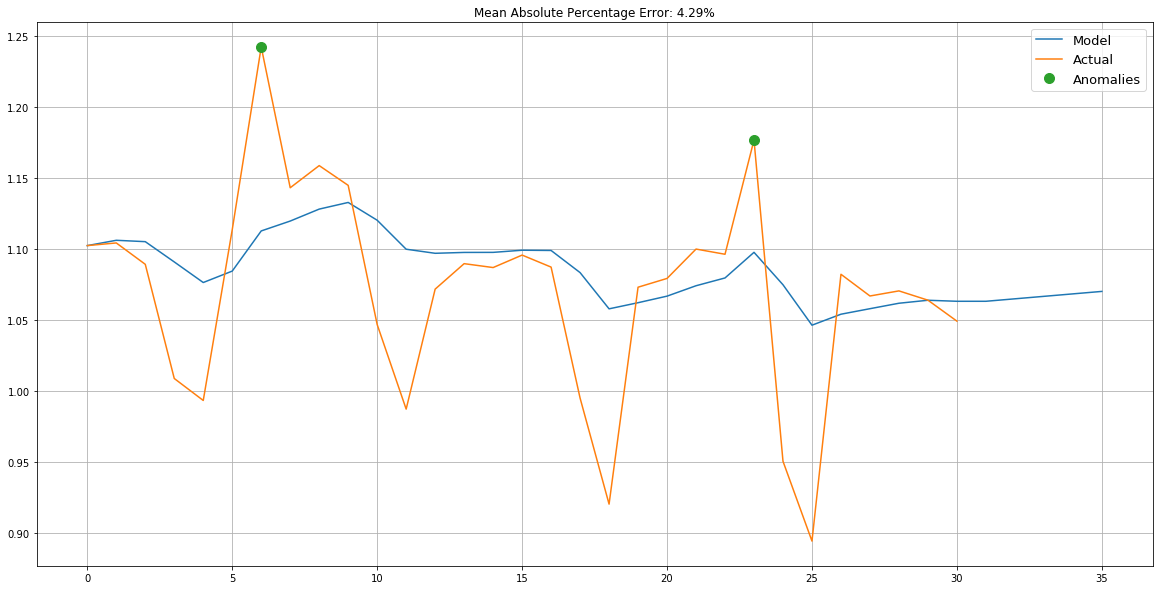

In [261]:
plotHoltWinters(national_df['ratio'], plot_intervals=False, plot_anomalies=True)

In [245]:
national_df['holts_winters'] = model.result[:-5]
national_df['upper_bound'] = [1.05*i for i in national_df['holts_winters']]
national_df['IS_ANOMALY'] = ['YES' if i > j else 'NO' for i, j in zip(national_df['ratio'], national_df['upper_bound'])]
national_df.to_csv('national_level_ratio_holts_winters_model.csv')

#### LEAKAGE RATIO AT DAY LEVEL ACROSS MARKETS

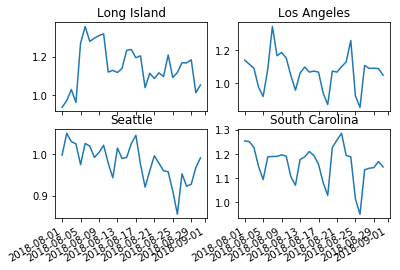

In [262]:
fig, ax = plt.subplots(nrows=2,ncols=2)
plt.title('Trends across Markets')
ax[0,0].plot(li_df['DAY'], li_df['ratio'])
ax[0,0].set_title('Long Island')
ax[0,1].plot(la_df['DAY'], la_df['ratio'])
ax[0,1].set_title('Los Angeles')
ax[1,0].plot(se_df['DAY'], se_df['ratio'])
ax[1,0].set_title('Seattle')
ax[1,1].plot(sc_df['DAY'], sc_df['ratio'])
ax[1,1].set_title('South Carolina')
fig.autofmt_xdate()

## Holt's Winter model results vs leakage ratio across markets


#### LEAKAGE RATIO AND ANOMALY COMPONENT OF LONG ISLAND

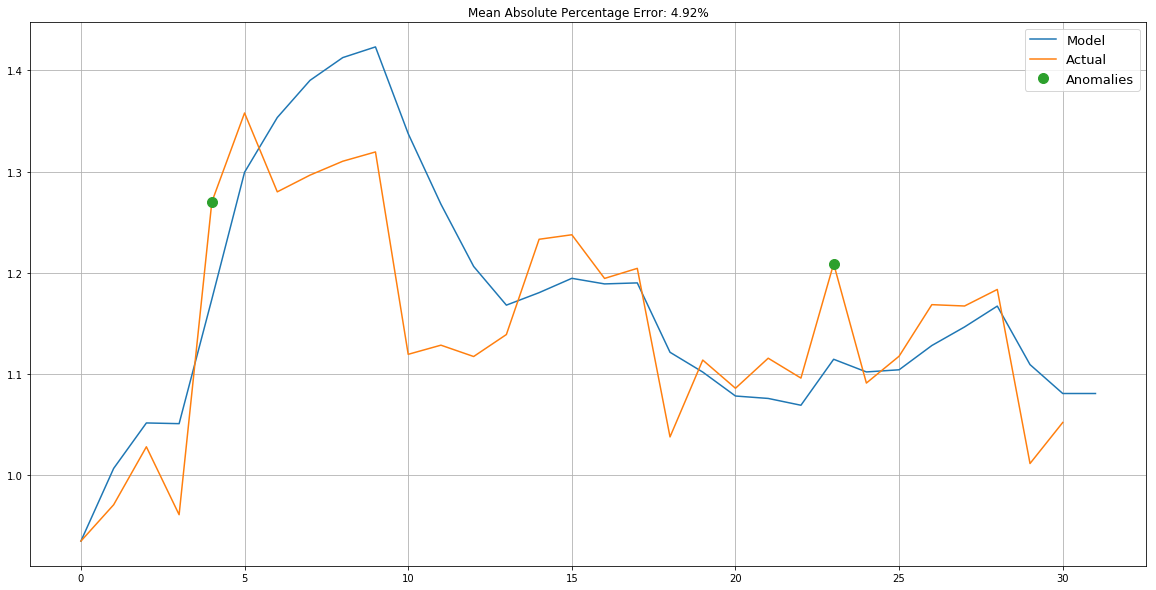

In [478]:
alpha_final, beta_final , gamma_final = 0.316, 0.25, 0.04
data= li_df['ratio'].reset_index(drop=True)
model = HoltWinters(data, 
                    slen = 1, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 1, 
                    scaling_factor = 3)
model.triple_exponential_smoothing()
plotHoltWinters(data, plot_intervals=False, plot_anomalies=True)

In [482]:
li_df['holts_winters'] = model.result[:-1]
li_df['upper_bound'] = [1.05*i for i in li_df['holts_winters']]
li_df['IS_ANOMALY'] = ['YES' if i > j else 'NO' for i, j in zip(li_df['ratio'], li_df['upper_bound'])]

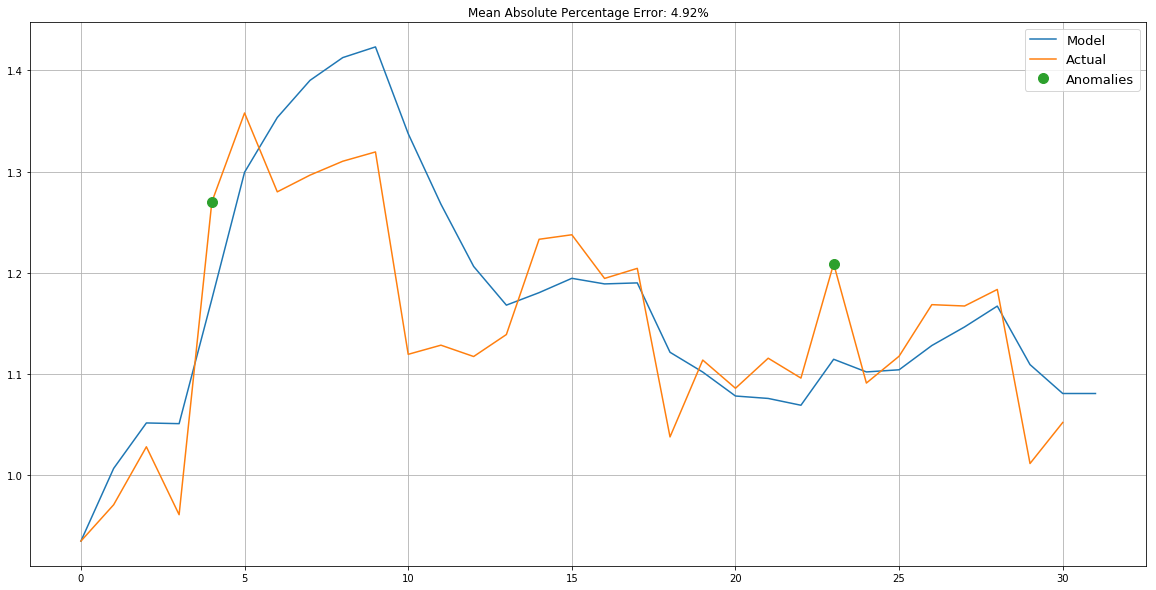

In [436]:
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x

data= li_df['ratio'].reset_index(drop=True)
model = HoltWinters(data, 
                    slen = 1, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 1, 
                    scaling_factor = 3)
model.triple_exponential_smoothing()
plotHoltWinters(data, plot_intervals=False, plot_anomalies=True)

#### RATIO AND ANOMALY COMPONENT OF LOS ANGELES

In [484]:
la_df['holts_winters'] = model.result[:-1]
la_df['upper_bound'] = [1.05*i for i in la_df['holts_winters']]
la_df['IS_ANOMALY'] = ['YES' if i > j else 'NO' for i, j in zip(la_df['ratio'], la_df['upper_bound'])]

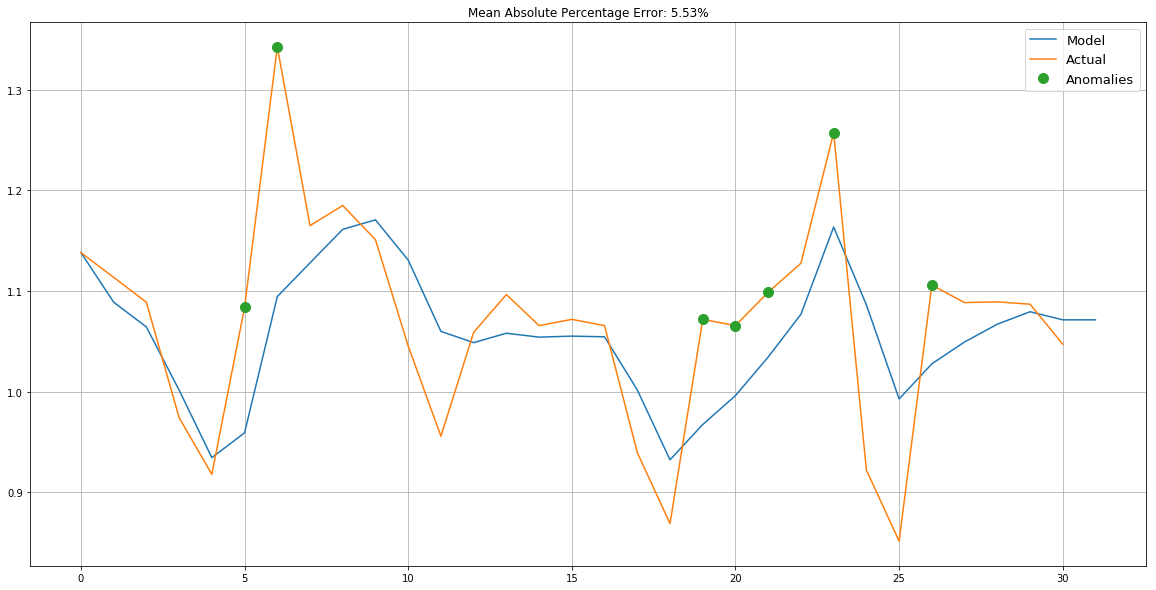

In [483]:
# opt = minimize(timeseriesCVscore, x0=x, 
#                args=(data, mean_squared_log_error), 
#                method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
#               )

#  alpha_final, beta_final, gamma_final = opt.x
alpha_final, beta_final , gamma_final = 0.316, 0.25, 0.04
data= la_df['ratio'].reset_index(drop=True)
model = HoltWinters(data, 
                    slen = 1, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 1, 
                    scaling_factor = 3)
model.triple_exponential_smoothing()
plotHoltWinters(data, plot_intervals=False, plot_anomalies=True)

#### RATIO AND ANOMALY COMPONENT OF SEATTLE

In [490]:
se_df['holts_winters'] = model.result[:-1]
se_df['upper_bound'] = [1.05*i for i in se_df['holts_winters']]
se_df['IS_ANOMALY'] = ['YES' if i > j else 'NO' for i, j in zip(se_df['ratio'], se_df['upper_bound'])]

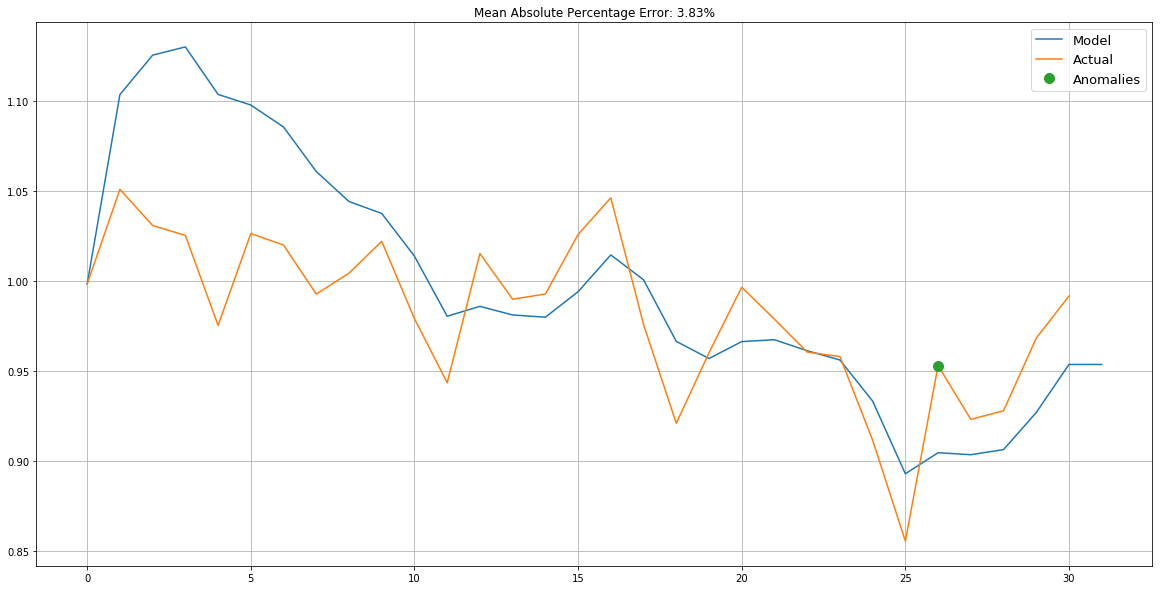

In [489]:
alpha_final, beta_final , gamma_final = 0.316, 0.25, 0.04
    
data= se_df['ratio'].reset_index(drop=True)
model = HoltWinters(data, 
                    slen = 1, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 1, 
                    scaling_factor = 3)
model.triple_exponential_smoothing()
plotHoltWinters(data, plot_intervals=False, plot_anomalies=True)

#### RATIO AND ANOMALY COMPONENT OF SOUTH CAROLINA

In [492]:
sc_df['holts_winters'] = model.result[:-1]
sc_df['upper_bound'] = [1.05*i for i in sc_df['holts_winters']]
sc_df['IS_ANOMALY'] = ['YES' if i > j else 'NO' for i, j in zip(sc_df['ratio'], sc_df['upper_bound'])]

In [495]:
market_level = pd.concat([li_df,la_df,se_df,sc_df],ignore_index=True)

In [496]:
market_level.to_csv('day_market_level_holt_winters.csv')

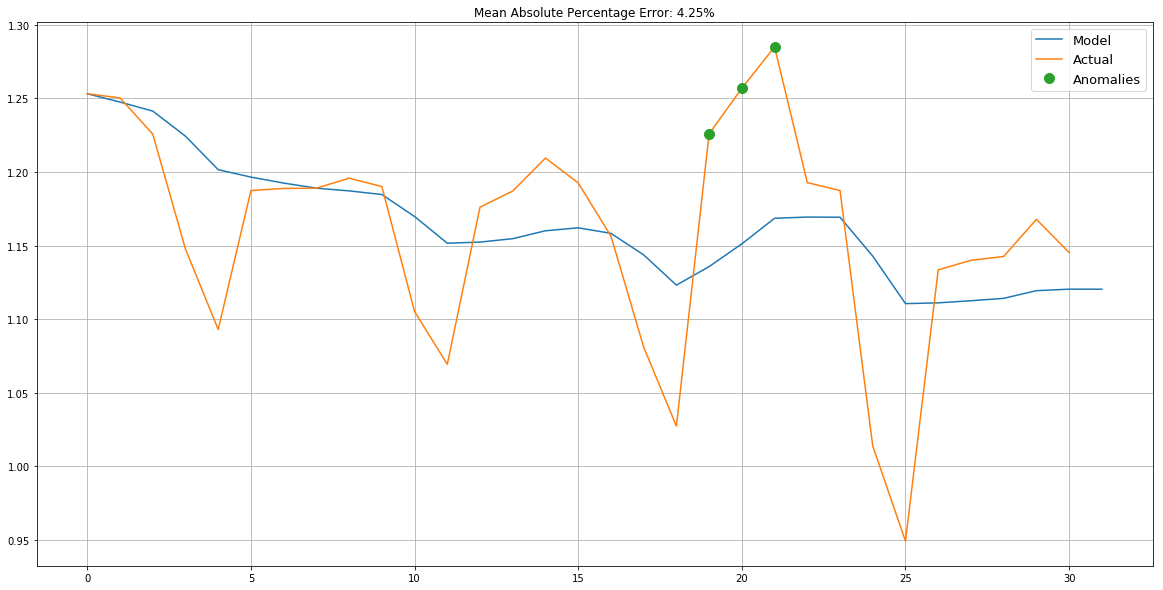

In [491]:
# opt = minimize(timeseriesCVscore, x0=x, 
#                args=(data, mean_squared_log_error), 
#                method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
#               )

#  alpha_final, beta_final, gamma_final = opt.x
alpha_final, beta_final , gamma_final = 0.116, 0.0025, 0.04 

data= sc_df['ratio'].reset_index(drop=True)
model = HoltWinters(data, 
                    slen = 1, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 1, 
                    scaling_factor = 3)
model.triple_exponential_smoothing()
plotHoltWinters(data, plot_intervals=False, plot_anomalies=True)